# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer


# magic word for producing visualizations in notebook
# took some help from https://github.com/chauhan-nitin/Udacity-IdentifyCustomerSegments-Arvato/blob/master/Identify_Customer_Segments.ipynb
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general Udacity_CUSTOMERS_Subset.csv.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Demographics data for the general population of Germany: {azdias.shape}')
print(f'Demographics data for customers of a mail-order company: {feat_info.shape}')

Demographics data for the general population of Germany: (891221, 85)
Demographics data for customers of a mail-order company: (85, 4)


In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
print(f'Missing values in azdias dataframe varibales: {azdias.isnull().sum(axis = 0)}')
null_data = azdias.isnull().sum()[azdias.isnull().sum() != 0]

data_dict = {'count': null_data.values, 'pct':np.round(null_data.values *100/891221,2)}

azdias_init_null = pd.DataFrame(data=data_dict, index=null_data.index)
azdias_init_null.sort_values(by='count', ascending=False, inplace=True)

Missing values in azdias dataframe varibales: AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                

In [8]:
azdias_init_null.shape

(53, 2)

In [9]:
from copy import deepcopy
feat_info_clean = feat_info.copy(deep=True)
azdias_clean = azdias.copy(deep=True)

In [10]:
feat_info_clean.missing_or_unknown = feat_info_clean.missing_or_unknown.str.replace('[','').str.replace(']','').str.split(',')
feat_info_clean.set_index(['attribute'], inplace=True)

In [11]:

feat_info_clean.missing_or_unknown.head(10)

attribute
AGER_TYP                    [-1, 0]
ALTERSKATEGORIE_GROB     [-1, 0, 9]
ANREDE_KZ                   [-1, 0]
CJT_GESAMTTYP                   [0]
FINANZ_MINIMALIST              [-1]
FINANZ_SPARER                  [-1]
FINANZ_VORSORGER               [-1]
FINANZ_ANLEGER                 [-1]
FINANZ_UNAUFFAELLIGER          [-1]
FINANZ_HAUSBAUER               [-1]
Name: missing_or_unknown, dtype: object

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
for attr in feat_info_clean.index:
    for x in feat_info_clean.loc[attr]['missing_or_unknown']:
        try:
            azdias_clean[attr].replace(int(x), np.nan, inplace=True)
        except ValueError:    
            azdias_clean[attr].replace(x, np.nan, inplace=True)           

In [13]:
print(f'Missing values in dataframe varibales: {azdias_clean.isnull().sum(axis = 0)}')

Missing values in dataframe varibales: AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
 

In [14]:

azdias_clean.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [15]:
# Check NaN for all columns 
dict_temp = {'count':azdias_clean.isnull().sum().values, \
             'pct':np.round(azdias_clean.isnull().sum().values *100/891221,2)}

pd.DataFrame(data=dict_temp, index=azdias.isnull().sum().index).describe()

,count,pct
count,85.000000,85.000000
mean,98516.811765,11.054000
std,146604.203317,16.450525
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.450000
75%,116515.000000,13.070000
max,889061.000000,99.760000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_val = azdias_clean.isnull().sum()


In [17]:
print(missing_val.count())

85


In [18]:
for x in range(missing_val.shape[0]):
    missing_val[x] = (missing_val[x]*100)/azdias_clean.shape[0]

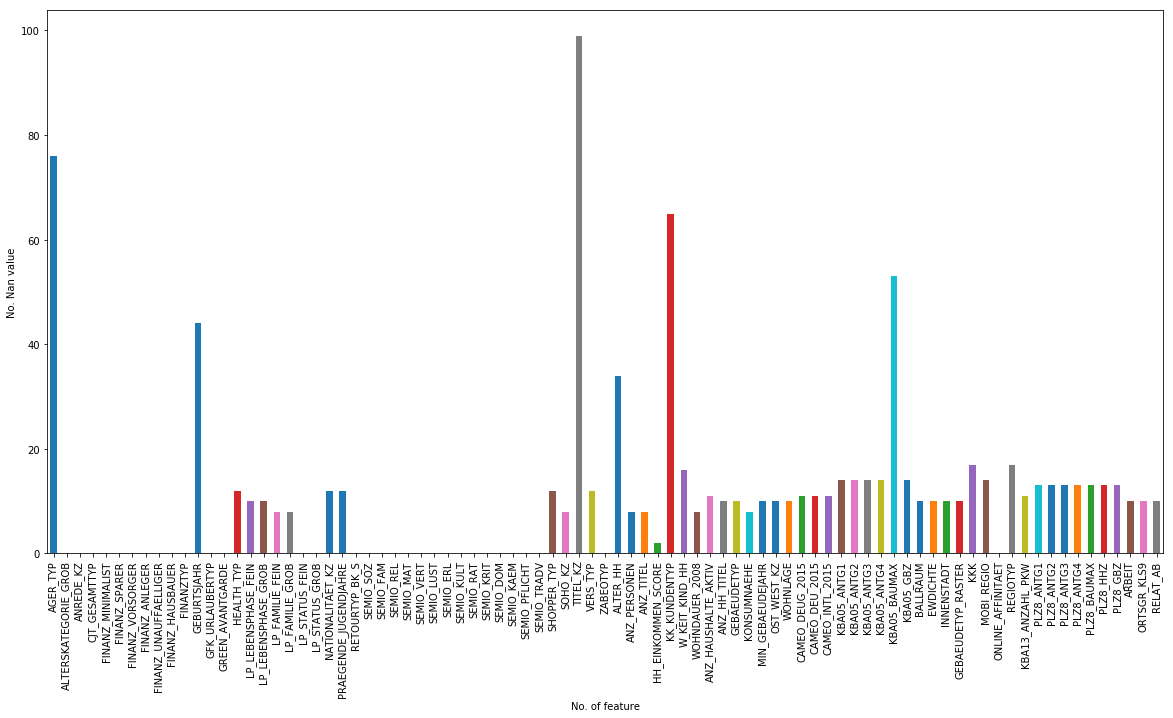

In [19]:
plt.xlabel('No. of feature')
plt.ylabel('No. Nan value')
missing_val.plot(kind='bar', figsize=(20,10))

In [20]:
# Investigate patterns in the amount of missing data in each column.
for x in range(missing_val.shape[0]):
    if missing_val[x] >= 20:
        print('Column', missing_val.index[x], 'Have', missing_val[x] , '%tage of missing values')

Column AGER_TYP Have 76 %tage of missing values
Column GEBURTSJAHR Have 44 %tage of missing values
Column TITEL_KZ Have 99 %tage of missing values
Column ALTER_HH Have 34 %tage of missing values
Column KK_KUNDENTYP Have 65 %tage of missing values
Column KBA05_BAUMAX Have 53 %tage of missing values


In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
del_cols = []
for i in range(missing_val.shape[0]):
    if missing_val[i] >= 20:
        del_cols.append(missing_val.index[i])


In [22]:
print(del_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [23]:
azdias_clean.drop(del_cols, axis=1, inplace=True)

In [24]:
azdias_clean.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the azdias df, the coulumns having more than 20% of missing values are dropped. A total of 6 columns were removed. The details of \% tage of missing values in each removed columns are as follows,

    . AGER_TYP Have 76 %tage of missing values
    . GEBURTSJAHR Have 44 %tage of missing values
    . TITEL_KZ Have 99 %tage of missing values
    . ALTER_HH Have 34 %tage of missing values
    . KK_KUNDENTYP Have 65 %tage of missing values
    . KBA05_BAUMAX Have 53 %tage of missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_clean.isnull().sum(axis=1)

In [26]:
missing_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

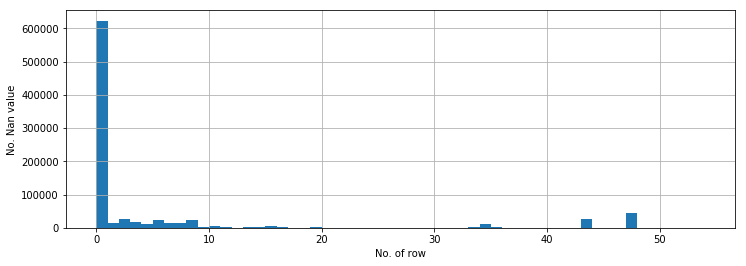

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
plt.figure(figsize=(12,4))
plt.xlabel('No. of row')
plt.ylabel('No. Nan value')
missing_rows.hist(bins=np.arange(0,55,1))

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets. group_1 more than 10 and group_2 otherwise
gruop_1 = []
gruop_2 = []
for x in range(missing_rows.shape[0]):
    if missing_rows[x] >= 10:
        gruop_1.append(missing_rows.index[x])
    else :
        gruop_2.append(missing_rows.index[x])

In [29]:
rows_many_missing = missing_rows[missing_rows > 10]
print(f'rows with many missing values: {rows_many_missing.shape[0]}') 
print(f'{np.round(rows_many_missing.shape[0]*100/missing_rows.shape[0],2)} % of all data')
     

rows with many missing values: 111068
12.46 % of all data


In [30]:
cols_missing_grp1 = azdias_clean.loc[gruop_1].isnull().sum()/azdias_clean.loc[gruop_1].shape[0]
cols_missing_grp2 = azdias_clean.loc[gruop_2].isnull().sum()/azdias_clean.loc[gruop_2].shape[0]

In [31]:
cols_missing = pd.concat({'gruop_1':cols_missing_grp1, 'gruop_2':cols_missing_grp2}, axis=1)

In [32]:
cols_missing.head(10)

,gruop_1,gruop_2
ALTERSKATEGORIE_GROB,0.002447,0.003351
ANREDE_KZ,0.000000,0.000000
CJT_GESAMTTYP,0.041673,0.000000
FINANZ_MINIMALIST,0.000000,0.000000
FINANZ_SPARER,0.000000,0.000000
FINANZ_VORSORGER,0.000000,0.000000
FINANZ_ANLEGER,0.000000,0.000000
FINANZ_UNAUFFAELLIGER,0.000000,0.000000
FINANZ_HAUSBAUER,0.000000,0.000000
FINANZTYP,0.000000,0.000000


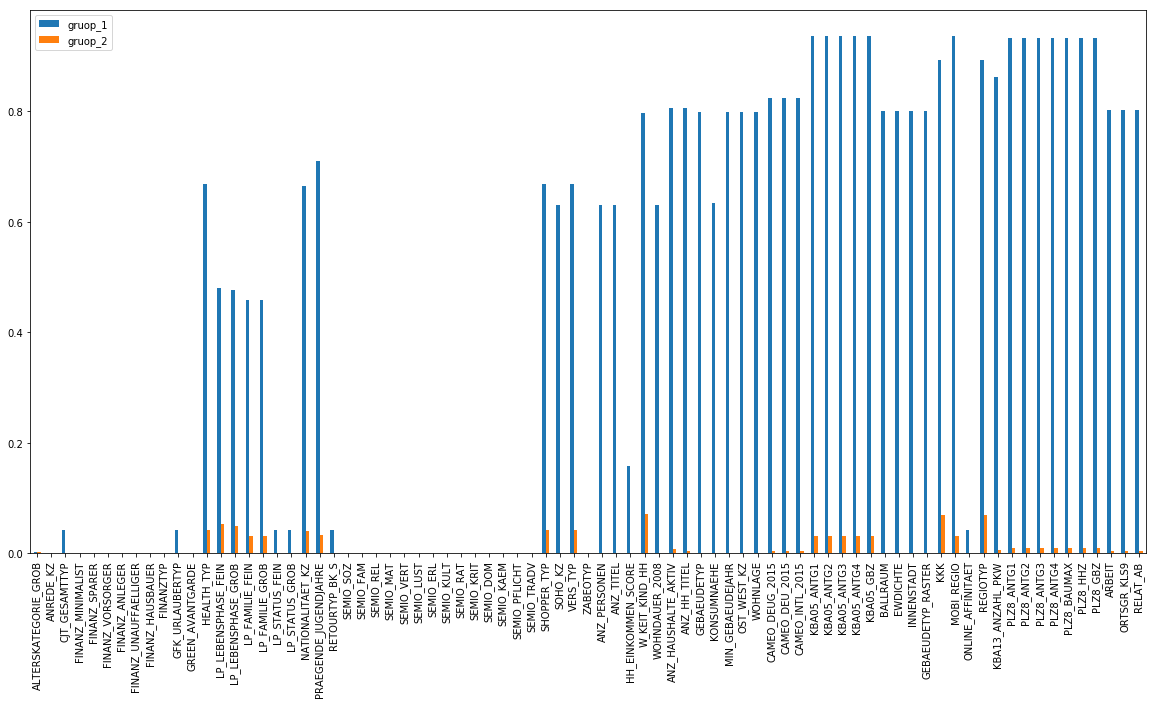

In [33]:
cols_missing.plot(kind='bar', figsize=(20,10))

In [34]:
def comparison_plot(column):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Large number of missing rows')
    sns.countplot(azdias_clean.loc[rows_many_missing.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Small number missing rows')
    sns.countplot(azdias_clean.loc[rows_many_missing.index,column]);

    fig.suptitle(column)
    plt.show()

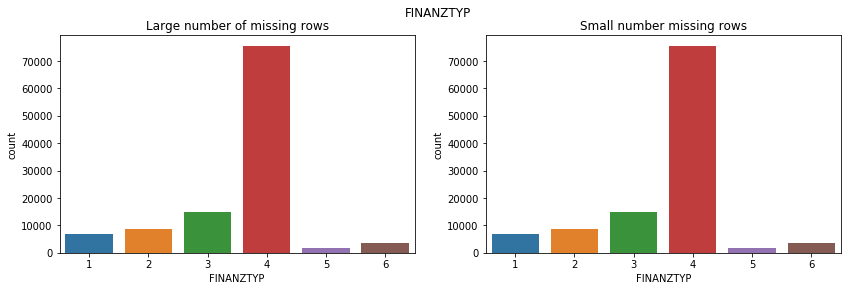

In [35]:
comparison_plot('FINANZTYP')

In [36]:
azdias_many_missing = azdias_clean.iloc[rows_many_missing.index]

In [37]:
# Drop rows with many missing values

print('rows before dropping null rows:', azdias_clean.shape[0])

azdias_clean_x = azdias_clean[~azdias_clean.index.isin(rows_many_missing.index)]

print('rows after dropping null rows:', azdias_clean.shape[0])

rows before dropping null rows: 891221
rows after dropping null rows: 891221


#### Discussion 1.1.3: Assess Missing Data in Each Row

111068 records or 12.46 % of all rows are missing 10 or more column values (out of 83). The dataset was divided between rows with many missing column values (more than 10) and rows with few ones. Its is cleat that the 88% of the rows has less than 11 missing value columns, while less than 12% has more than 11 columns. I assigned the 88\% of data group_1 and the group_2 for less than \%12. 

In [38]:
azdias_clean_grp = azdias_clean.loc[gruop_2]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [39]:
feat_info_clean.head(5)

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [40]:
# How many features are there of each data type?
feat_info_clean['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
cat = feat_info_clean[feat_info_clean['type'] == 'categorical'].index
cat

Index(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP',
       'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object', name='attribute')

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_content = {col: azdias_clean_grp[col].unique() for col in cat 
               if col not in del_cols}

In [43]:
cols_del_cat = [k for k,v in cat_content.items() if len(v) > 2]
len(cols_del_cat)

14

In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean_grp['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_clean_grp['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias_clean_grp['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [45]:
azdias_clean_grp['OST_WEST_KZ'].value_counts()

1    610258
0    164485
Name: OST_WEST_KZ, dtype: int64

In [46]:
azdias_clean_grp.drop(cols_del_cat, axis=1, inplace=True)

In [47]:

azdias_clean_grp.shape

(774743, 65)

In [48]:
azdias_clean_grp.reset_index(inplace=True)
azdias_clean_grp.drop('index', axis=1, inplace=True)
azdias_clean_grp.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,1,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,1,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
5,2.0,1,1,5,1,5,4,3,0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
6,1.0,0,3,3,4,1,3,2,0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
7,3.0,0,4,4,2,4,2,2,1,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
8,3.0,1,2,4,2,3,5,4,1,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
9,3.0,1,2,2,5,3,1,5,0,2.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

In the case of the categorical features, the binary columns were kept while the 14 columns that had more 2 categories were deleted.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
!tail -50 Data_Dictionary.md

-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

-----

## 9. Community-level features

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants

### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
- 

In [50]:
#mixed = feat_info_clean[feat_info_clean['type'] == 'mixed']["attribute"]
mixed = feat_info_clean[feat_info_clean["type"]=="mixed"].index
mixed

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [51]:
azdias_clean_grp[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
0,14.0
1,15.0
2,8.0
3,8.0
4,3.0


In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_clean_grp['DECADE'] = azdias_clean_grp['PRAEGENDE_JUGENDJAHRE']
azdias_clean_grp['MOVEMENT'] = azdias_clean_grp['PRAEGENDE_JUGENDJAHRE']

In [53]:

decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [54]:
azdias_clean_grp['DECADE'].replace(decade_dict, inplace=True)
azdias_clean_grp['MOVEMENT'].replace(movement_dict, inplace=True)

In [55]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean_grp['WEALTH'] = azdias_clean_grp['CAMEO_INTL_2015']
azdias_clean_grp['LIFE_STAGE'] = azdias_clean_grp['CAMEO_INTL_2015']

In [56]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [57]:
azdias_clean_grp['WEALTH'].replace(wealth_dict, inplace=True)
azdias_clean_grp['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [58]:
azdias_clean_grp.shape

(774743, 69)

In [59]:
azdias_clean_grp.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,1,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,1,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
5,2.0,1,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0
6,1.0,0,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,1.0,4.0
7,3.0,0,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,5.0,0.0,1.0,3.0
8,3.0,1,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,6.0,0.0,1.0,5.0
9,3.0,1,2,2,5,3,1,5,0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,2.0,1.0,5.0,1.0


In [60]:
# Now drop features we don't use anymore 
azdias_clean_grp = azdias_clean_grp.drop(['KKK', 'REGIOTYP'], axis=1)

In [61]:
mixed = [x for x in mixed if x in azdias_clean_grp.columns]
azdias_clean_grp.drop(mixed, axis=1, inplace=True) # drop mixed features for complexity reduction

In [62]:
azdias_clean_grp.shape

(774743, 61)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Two mixed-value features kept:

    PRAEGENDE_JUGENDJAHRE
    CAMEO_INTL_2015
    
Feature engineer on two mixed-value features:

    Created two new feature columns, and copied values from the initial mixed-value feature column
    Created two dictionaries to map intial feature values to new feature values
    Performed a replace operation using the dictionaries on the new feature columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [63]:
azdias_clean_grp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
       'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9',
       'RELAT_AB', 

In [64]:
#checking columns datatype
np.unique(azdias_clean_grp.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(f'Missing values in dataframe varibales: {azdias_clean_grp.isnull().sum(axis = 0)}')

Missing values in dataframe varibales: ALTERSKATEGORIE_GROB      2596
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               33420
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH           55257
                         ...  


In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_clean_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774743 entries, 0 to 774742
Data columns (total 61 columns):
ALTERSKATEGORIE_GROB     772147 non-null float64
ANREDE_KZ                774743 non-null int64
FINANZ_MINIMALIST        774743 non-null int64
FINANZ_SPARER            774743 non-null int64
FINANZ_VORSORGER         774743 non-null int64
FINANZ_ANLEGER           774743 non-null int64
FINANZ_UNAUFFAELLIGER    774743 non-null int64
FINANZ_HAUSBAUER         774743 non-null int64
GREEN_AVANTGARDE         774743 non-null int64
HEALTH_TYP               741323 non-null float64
RETOURTYP_BK_S           774743 non-null float64
SEMIO_SOZ                774743 non-null int64
SEMIO_FAM                774743 non-null int64
SEMIO_REL                774743 non-null int64
SEMIO_MAT                774743 non-null int64
SEMIO_VERT               774743 non-null int64
SEMIO_LUST               774743 non-null int64
SEMIO_ERL                774743 non-null int64
SEMIO_KULT               774743 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_df(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info= pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    from copy import deepcopy
    feat_info_clean = feat_info.copy(deep=True)
    df_clean = df.copy(deep=True)
    
    feat_info_clean.missing_or_unknown = feat_info_clean.missing_or_unknown.str.replace('[','').str.replace(']','').str.split(',')
    feat_info_clean.set_index(['attribute'], inplace=True)

    for attr in feat_info_clean.index:
        for x in feat_info_clean.loc[attr]['missing_or_unknown']:
            try:
                df[attr].replace(int(x), np.nan, inplace=True)
            except ValueError:    
                df[attr].replace(x, np.nan, inplace=True)
                    
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                    #print(x)
                else:
                    hold.append(int(x))
            df_clean[column_name] = df_clean[column_name].replace(hold,np.nan)
            
    #df.replace(to_replace =["Boston Celtics", "Texas"], value ="Omega Warrior")
    # convert missing value codes into NaNs, ...
    missing_val = df_clean.isnull().sum()
    #del_cols = []
    #for i in range(missing_val.shape[0]):
    #    if missing_val[i] >= 20:
    #        del_cols.append(missing_val.index[i])
    
    ##df_clean.drop(del_cols, axis=1, inplace=True)

    del_cols = []
    for i in range(missing_val.shape[0]):
        if missing_val[i] >= 20:
            del_cols.append(missing_val.index[i])
    
    # Delete columns with more than 30% of NaNs    
    
    del_cols_nan = missing_val[(missing_val)/df_clean.shape[0] > 0.3].index
    df_clean.drop(del_cols_nan, axis=1, inplace=True)
    
    # Delete rows with more than 10% of NaNs  
    missing_rows = df_clean.isnull().sum(axis=1)
    rows_many_missing = missing_rows[missing_rows > 10]
    azdias_many_missing = df_clean.iloc[rows_many_missing.index]

    #print('rows before dropping null rows:', df_clean.shape[0])

    df_clean = df_clean[~df_clean.index.isin(rows_many_missing.index)]
    
    df_clean.reset_index(inplace=True)
    df_clean.drop('index', axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    categorical = feat_info_clean[feat_info_clean['type'] == 'categorical'].index
    
    cat_content = {col: df_clean[col].unique() for col in cat 
               if col not in del_cols_nan}
    
    cols_del_cat = [k for k,v in cat_content.items() if len(v) > 2]
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df_clean['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df_clean['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df_clean['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    df_clean.drop(cols_del_cat, axis=1, inplace=True)
    df_clean.reset_index(inplace=True)
    df_clean.drop('index', axis=1, inplace=True)
    
    #mixed = feat_info_clean[feat_info_clean['type'] == 'mixed']["attribute"]
    mixed = feat_info_clean[feat_info_clean["type"]=="mixed"].index
    
    
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    df_clean = df_clean.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    mixed = [x for x in mixed if x in df_clean.columns]
    df_clean.drop(mixed, axis=1, inplace=True) # drop mixed features for complexity reduction
    # Return the cleaned dataframe.
    
    return df_clean

In [68]:
#ustomers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [69]:
#cust_clean=clean_df(customers)

In [70]:
#azdias_clean_grp.shape

In [71]:
#from sklearn.preprocessing import Imputer
#imputer = Imputer(strategy='most_frequent', axis=0)
#imputed_features = imputer.fit_transform(cust_clean)

In [72]:
#azdias_clean_grp.columns.difference(azdias_clean_grp.columns)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
features = azdias_clean_grp.copy()

# Impute nans
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='most_frequent', axis=0)
imputed_features = imputer.fit_transform(features)


In [74]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)


### Discussion 2.1: Apply Feature Scaling

The nan were imputed using the most_frequent (mode) value per column. The median was chosen, instead of the mean, because it is more robust against outliers. The features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(X, n_components):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    '''    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

Code from the course content**

In [76]:
def plot_pca(pca):
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.figure(figsize=(18, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Dataset Explained Variance')
    plt.title('Explained Variance Per Principal Component')
    plt.show()
    

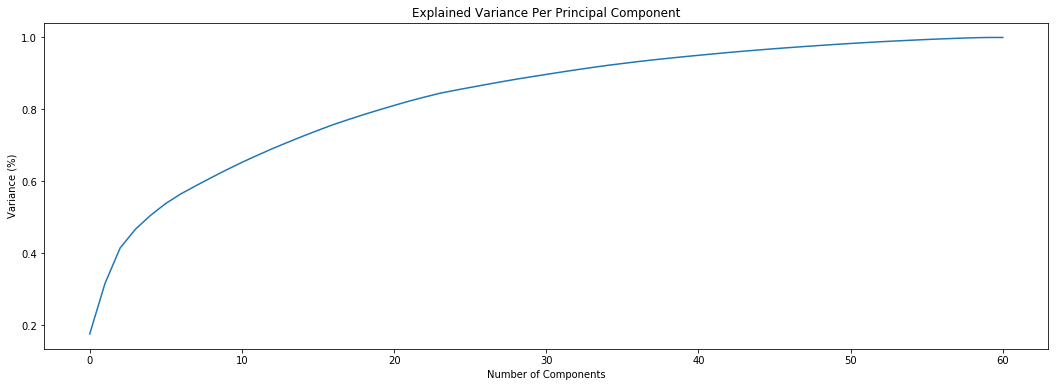

In [77]:
pca, X_pca = do_pca(standardized_features, 61)
plot_pca(pca)

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(standardized_features, 45)

In [79]:
pca

PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

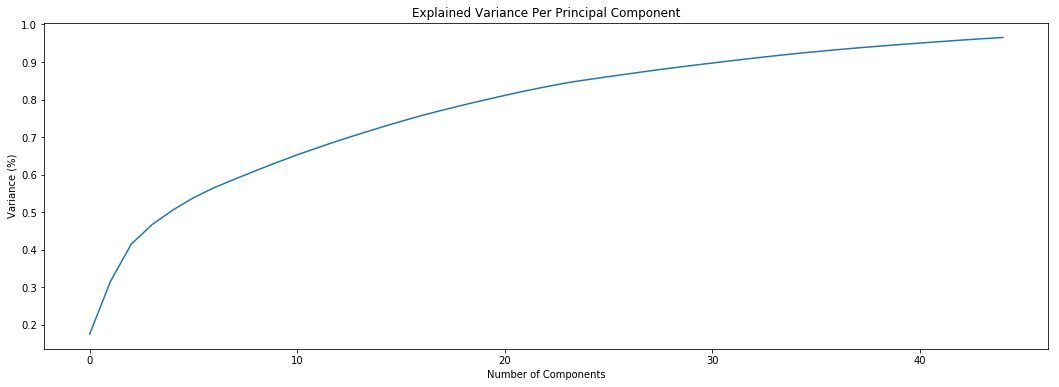

In [80]:
plot_pca(pca)

### Discussion 2.2: Perform Dimensionality Reduction

This cumulative summation plot suggested that selecting 45 components we can preserve something around 98.8% or 99% of the total variance of the data. It makes sense, we’ll not use 100% of our variance, because it denotes all components, and we want only the principal ones.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [81]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca, cols, component):
    pca_component =  pd.DataFrame({'attribute': cols, 'weight': pca.components_[component], \
                          'weight_abs': np.abs(pca.components_[component])})
    
    #compo = pd.concat([pca_component.head(5), pca_component.tail(5)])
    #compo.plot(kind='bar', title='Component ' + str(component))
    #ax = plt.gca()
    ##ax.grid(linewidth='0.5', alpha=0.5)
    #ax.set_axisbelow(True)
    #plt.show()
    pca_component= pca_component.sort_values(by=['weight'], ascending=False)
    n = 5
    head_tail = pd.concat([pca_component[:n], pca_component[-n:]])
    return head_tail

In [82]:

comp_0 = map_weights(pca, azdias_clean_grp.columns, 0)
comp_0

,attribute,weight,weight_abs
50,PLZ8_ANTG3,0.226243,0.226243
51,PLZ8_ANTG4,0.218275,0.218275
59,WEALTH,0.204328,0.204328
28,HH_EINKOMMEN_SCORE,0.201424,0.201424
55,ORTSGR_KLS9,0.197089,0.197089
40,KBA05_GBZ,-0.215969,0.215969
36,KBA05_ANTG1,-0.217154,0.217154
2,FINANZ_MINIMALIST,-0.222898,0.222898
48,PLZ8_ANTG1,-0.226167,0.226167
45,MOBI_REGIO,-0.229399,0.229399


In [83]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_1 = map_weights(pca, azdias_clean_grp.columns, 1)
comp_1

,attribute,weight,weight_abs
0,ALTERSKATEGORIE_GROB,0.256507,0.256507
17,SEMIO_ERL,0.229782,0.229782
4,FINANZ_VORSORGER,0.228793,0.228793
16,SEMIO_LUST,0.179445,0.179445
10,RETOURTYP_BK_S,0.163227,0.163227
23,SEMIO_PFLICHT,-0.226832,0.226832
24,SEMIO_TRADV,-0.227855,0.227855
3,FINANZ_SPARER,-0.231718,0.231718
57,DECADE,-0.239047,0.239047
13,SEMIO_REL,-0.254326,0.254326


In [84]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_2 = map_weights(pca, azdias_clean_grp.columns, 2)
comp_2

,attribute,weight,weight_abs
15,SEMIO_VERT,0.346232,0.346232
11,SEMIO_SOZ,0.262775,0.262775
12,SEMIO_FAM,0.249058,0.249058
18,SEMIO_KULT,0.233298,0.233298
2,FINANZ_MINIMALIST,0.155776,0.155776
19,SEMIO_RAT,-0.217822,0.217822
20,SEMIO_KRIT,-0.273545,0.273545
21,SEMIO_DOM,-0.313851,0.313851
22,SEMIO_KAEM,-0.336113,0.336113
1,ANREDE_KZ,-0.368146,0.368146


In [85]:
!grep -i "SEMIO*" Data_Dictionary.md

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV


In [86]:
azdias_clean_grp.shape

(774743, 61)

### Discussion 2.3: Interpret Principal Components
We have both positive and negative weights. The postitive value mean postive relationship between factor and variable and vice versa.

The first principal component has a positive association with:

    PLZ8_ANTG3	- is number of 6–10 family houses in the zipcode (3 = high share)
    PLZ8_ANTG4	- Number of 10+ family houses in the PLZ8 region
    PLZ8_BAUMAX - Most common building type within the PLZ8 region
    WEALTH - Household wealth (higher is lower income)

and negative association with:

    KBA05_GBZ  - Number of buildings in the microcell
    PLZ8_ANTG1 - is number of 1–2 family houses in the zipcode (3 = high share)
    MOBI_REGIO - Movement patterns
   
It seems that the first component explains the indiviudal financial status, movement, and share of family members in homes.

The second principal component has a positive association with:

    ALTERSKATEGORIE_GROB - Estimated age based on given name analysis (higher is older)
    FINANZ_VORSORGER - Financial typology, be prepared (higher is lower topology)
    SEMIO_ERL - Personality typology, event oriented 
    

and negative association with:

    FINANZ_SPARER - Financial typology (money saver)
    SEMIO_TRADV	- Personality typology (tradional-minded)
    SEMIO_REL - Personality typology (religious)

It appears that  the second component is linked to age, decade of movement, and financial savings. This component is focused on the age, personal characteristics and financial habits.

The third principal component has a positive association with:
    
    SEMIO_VERT - Personality typology (dreamful)
    SEMIO_SOZ - Personality typology (socially-minded)
    SEMIO_FAM - Personality typology (family-minded)
    SEMIO_KULT - Personality typology (cultural-minded)

and negative association with:

    SEMIO_KRIT - Personality typology (critical-minded)
    SEMIO_DOM - Personality typology (dominant-minded)
    SEMIO_KAEM - Personality typology (combative attitude)
    ANREDE_KZ - Gender
 
It looks the third component explains the personaly charecterstics and gender. For instance,the negative, ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM and SEMIO_KRIT show the gender, and combative attitude,  dominant and critical minded personalities. The component decreases as these values increase. In this component, the kind of personalities are well explained. For instance, family oriented and dominant personalities are on the opposite scale of component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
X_pca.shape

(774743, 45)

In [88]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
import time 
def get_kmeans_avg_dist(X, n_clusters):   
    kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_jobs = -1)
    model = kmeans.fit(X)
    
    # Average distance of samples from their respective centroids
    avg_distance = np.abs(model.score(X))/X.shape[0]
    return avg_distance
    

In [89]:
start_time = time.time()
get_kmeans_avg_dist(X_pca, 10)
print(f' Clustering run time (minutes): {np.round(((time.time() - start_time)/60),2)}')

 Clustering run time (minutes): 2.97


In [90]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

average_distances = list()
for i in range(1,20):
    avg_dist = get_kmeans_avg_dist(X_pca, i)
    average_distances.append(avg_dist)
    print(f'Average distance of samples from centroids for {i} clusters is { np.around(avg_dist, 3)}')

Average distance of samples from centroids for 1 clusters is 58.887
Average distance of samples from centroids for 2 clusters is 50.892
Average distance of samples from centroids for 3 clusters is 46.737
Average distance of samples from centroids for 4 clusters is 44.141
Average distance of samples from centroids for 5 clusters is 42.31
Average distance of samples from centroids for 6 clusters is 40.718
Average distance of samples from centroids for 7 clusters is 39.271
Average distance of samples from centroids for 8 clusters is 38.204
Average distance of samples from centroids for 9 clusters is 37.494
Average distance of samples from centroids for 10 clusters is 36.586
Average distance of samples from centroids for 11 clusters is 36.124
Average distance of samples from centroids for 12 clusters is 35.657
Average distance of samples from centroids for 13 clusters is 35.215
Average distance of samples from centroids for 14 clusters is 34.678
Average distance of samples from centroids f

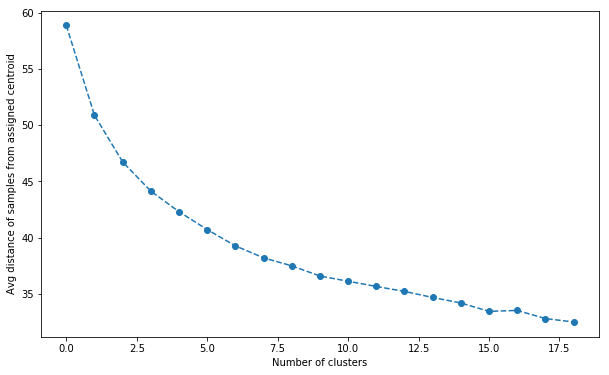

In [91]:
plt.figure(figsize=(10,6))
scalar_points = [*range(len(average_distances))]
plt.plot(scalar_points, average_distances, marker='o', linestyle='dashed')
plt.xlabel("Number of clusters")
plt.ylabel("Average distance of samples from centroid")
plt.show()

In [93]:
#Silhoutte score
from sklearn.metrics import silhouette_score
def get_silhouette_score(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_jobs = -1)

    indices = kmeans.fit_predict(X)
    score = silhouette_score(X, indices, sample_size=20000, random_state=0)
    return score

In [94]:
start_time = time.time()
score = get_silhouette_score(X_pca, 10)
print(f' Silhouette run time (minutes): {np.round(((time.time() - start_time)/60),2)}')

 Silhouette run time (minutes): 4.48


In [95]:
score

0.096089618552048381

In [96]:
start_time = time.time()
s_scores = list()
for i in range(2,15):
    score = get_silhouette_score(X_pca, i)
    s_scores.append(score)
    print(f'Silhouette score for {i} clusters is {np.around(score, 3)}')
print(f' Silhouette run time (minutes): {np.round(((time.time() - start_time)/60),2)}')

Silhouette score for 2 clusters is 0.13
Silhouette score for 3 clusters is 0.117
Silhouette score for 4 clusters is 0.105
Silhouette score for 5 clusters is 0.094
Silhouette score for 6 clusters is 0.096
Silhouette score for 7 clusters is 0.102
Silhouette score for 8 clusters is 0.1
Silhouette score for 9 clusters is 0.097
Silhouette score for 10 clusters is 0.096
Silhouette score for 11 clusters is 0.095
Silhouette score for 12 clusters is 0.088
Silhouette score for 13 clusters is 0.084
Silhouette score for 14 clusters is 0.09
 Silhouette run time (minutes): 47.48


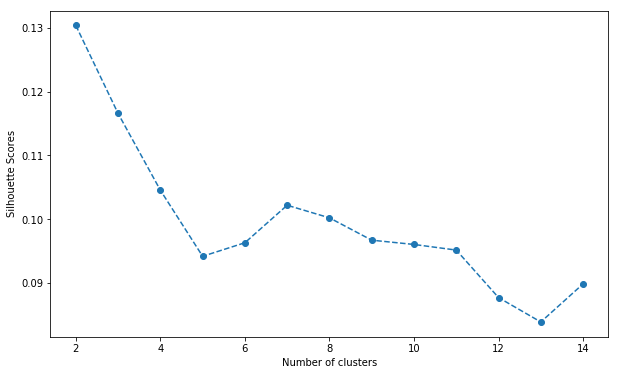

In [97]:
plt.figure(figsize=(10,6))
scalar_points = [*range(len(s_scores))]
scalar_points = [x.__add__(2) for x in scalar_points]
plt.plot(scalar_points, s_scores, marker='o', linestyle='dashed')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Scores")
plt.show()

In [98]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 7

start_time = time.time()
kmeans = KMeans(n_clusters = n_clusters, n_jobs = -1)
model = kmeans.fit(X_pca)
predict_general = model.predict(X_pca)
print(f' Clustering run time (minutes): {np.round(((time.time() - start_time)/60),2)}')

 Clustering run time (minutes): 1.69


### Discussion 3.1: Apply Clustering to General Population

This sample was used to make kmeans models with range of  1 to 20 centers, with their absolute score plotted in a scatter plot. Picking 7 as the number of clusters seems to be a good option which is also supported by the silhouette scores. Silhouette score measures the affinity of a sample to it's own cluster than to other clusters. Higher the value, better are the clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [100]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [101]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_df(customers)

In [102]:
np.unique(customers_clean.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [103]:
cust_imputed=imputer.fit_transform(customers_clean)

In [104]:
scaled_customers =  scaler.fit_transform(cust_imputed)

In [105]:
scaled_cust_df = pd.DataFrame(scaled_customers)
scaled_cust_df.columns = customers_clean.columns #restoring column names
scaled_cust_df.index = scaled_cust_df.index #restoring indeces

In [106]:
print(scaled_cust_df.head(5))

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              0.698871  -0.702215           0.719454       -0.51282   
1              0.698871   1.424065           0.719454       -0.51282   
2              0.698871  -0.702215           0.719454       -0.51282   
3             -0.680810  -0.702215          -1.246355       -0.51282   
4             -0.680810  -0.702215           0.719454       -0.51282   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          0.512633       -0.598101               0.159150         -0.564386   
1          0.512633       -0.598101               2.231136          0.956607   
2          0.512633        0.402968              -0.876844         -0.564386   
3         -0.680580        2.405104               3.267129         -0.564386   
4          0.512633       -0.598101               0.159150          0.196111   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
0      

In [107]:

#transform the customers data using pca object
pca_df = pca.transform(scaled_cust_df)

In [108]:

# Apply clustering from the general
# demographics onto the customer data, 
# obtaining cluster predictions for the
# customer demographics data.

customer_predict = model.predict(pca_df)

In [109]:
customer_predict

array([3, 4, 3, ..., 3, 4, 2], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

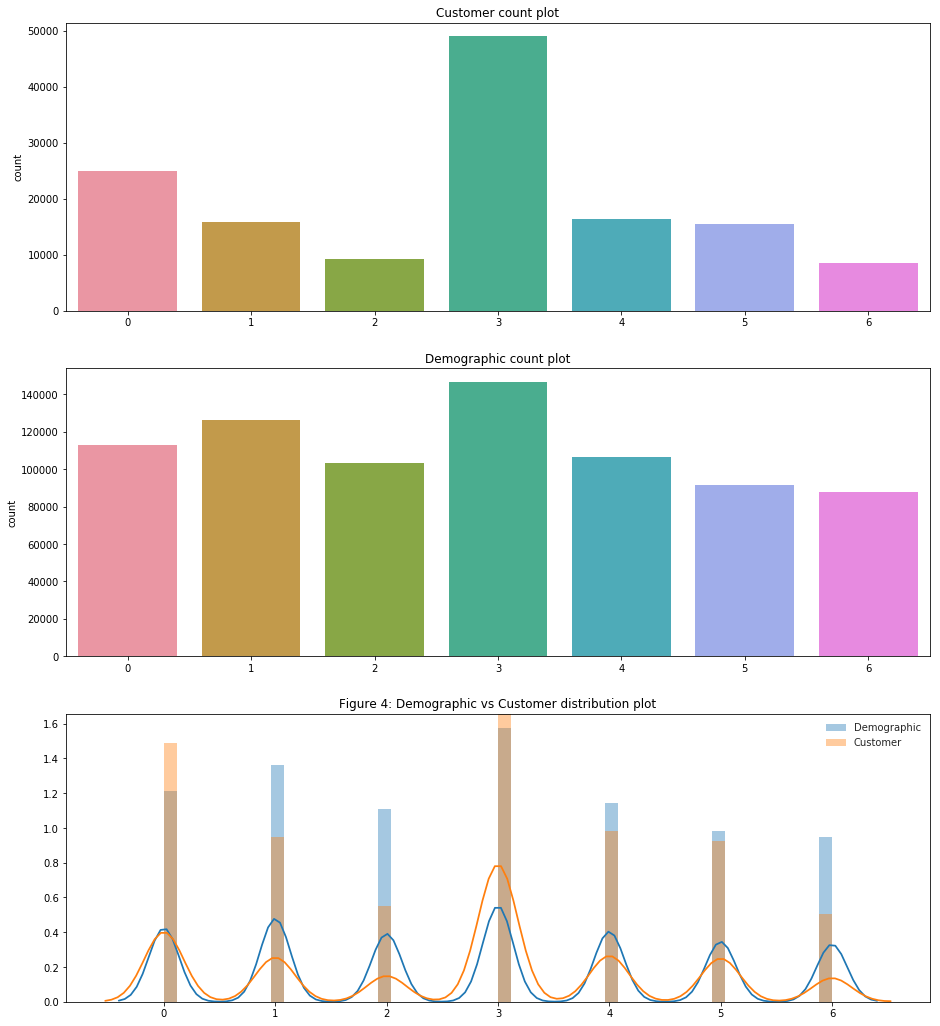

In [110]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Figure 4: Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(predict_general, label='Demographic',ax=ax)
sns.distplot(customer_predict, label='Customer', ax=ax)
sns.countplot(predict_general, label='Demographic', ax=ax2)
sns.countplot(customer_predict, label='Customer', ax=ax3)
ax.legend();

In [111]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cust_df = pd.DataFrame(customer_predict,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(customer_predict)*100
pop_df = pd.DataFrame(predict_general,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(predict_general)*100
diff = (cust_df-pop_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
pop_df.rename_axis({'index':'PopPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(pop_df)
diff.fillna(0, inplace=True)
diff.sort_values(by=['DiffPerc'], ascending=False)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,DiffPerc,CustPerc,PopPerc
Cluster,,,
3,16.268666,35.197007,18.928341
0,3.340016,17.888969,14.548954
5,-0.694183,11.100180,11.794363
4,-1.964673,11.774463,13.739137
1,-4.977728,11.344330,16.322058
6,-5.280496,6.075011,11.355508
2,-6.691601,6.620039,13.311640


In [112]:
def concat_cluster_df(predict1, predict2):
    
    x = np.array(predict1)
    y = np.array(predict2)
    cluster, counts = np.unique(x, return_counts=True)
  
    df1 = pd.DataFrame({'Cluster': cluster, 'Counts': counts})
    
    cluster, counts = np.unique(y, return_counts=True)
    
    df2 = pd.DataFrame({'Cluster': cluster, 'Counts': counts})
  
    df = pd.concat([df1, df2], axis=1, join='outer', ignore_index=True, keys='Cluster')
  
    df.drop([2], axis = 1, inplace = True)
  
    df.rename(columns = {0: 'Cluster', 1: 'General', 3: 'Customer'}, inplace = True)
  
    df['General_Proportion'] = round(df['General'] / df['General'].sum() * 100, 2)
    df['Customer_Proportion'] = round(df['Customer'] / df['Customer'].sum() * 100, 2)
  
    return df

In [113]:
df_plt = concat_cluster_df(predict_general, customer_predict )

In [114]:
df_plt

,Cluster,General,Customer,General_Proportion,Customer_Proportion
0,0,112717,24912,14.55,17.89
1,1,126454,15798,16.32,11.34
2,2,103131,9219,13.31,6.62
3,3,146646,49015,18.93,35.20
4,4,106443,16397,13.74,11.77
5,5,91376,15458,11.79,11.10
6,6,87976,8460,11.36,6.08


In [115]:
def plot_cluster_comparison(df):
    barWidth = 0.3
    r1 = np.arange(df.shape[0])
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(8,6))

    plt.bar(r1, df['General_Proportion'], width = barWidth, edgecolor = 'black', capsize=12, label='General Population')

  # Create cyan bars
    plt.bar(r2, df['Customer_Proportion'], width = barWidth,  edgecolor = 'black',  capsize=12, label='Customers')


  # general layout
    plt.xlabel('Cluster No.', fontsize = 12)
    plt.ylabel('Percentage (%)', fontsize = 12)
    plt.title("Comparing Proportion of People in Each Cluster", size = 14)
    plt.legend()

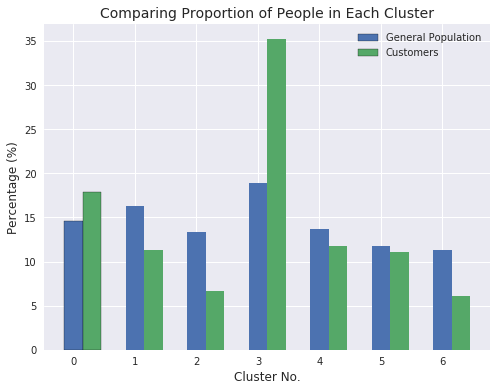

In [116]:
plot_cluster_comparison(df_plt)

In [117]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_)), columns=azdias_clean_grp.columns)
cluster_specs


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.845009,-0.141503,4.401816,1.108380,4.948242,0.856287,1.295105,3.116788,0.362152,2.157488,...,0.991045,3.751792,3.063297,3.301847,6.482786,3.546203,2.262546,0.630366,3.573202,2.883525
1,3.984298,0.732201,4.918277,0.867507,5.038028,1.419808,1.385132,2.244630,0.718957,1.827219,...,0.144885,3.497005,4.079824,2.439677,3.963828,2.339763,2.150470,0.273614,1.650834,3.879804
2,2.736414,-0.184355,3.745962,2.309060,3.741030,2.214778,2.768652,2.702254,0.489627,1.948293,...,0.609805,3.697748,3.560480,2.955453,5.371011,3.027241,4.120979,0.502910,2.851800,3.128039
3,3.815353,-0.106529,5.401278,0.909857,4.973176,1.031977,1.458592,1.666522,0.705128,1.972798,...,0.132436,3.482907,4.077774,2.393018,3.946508,2.337842,2.274800,0.287442,1.649589,3.852641
4,4.027164,0.774619,3.876385,0.970802,5.088763,1.203177,1.222762,3.869151,0.321841,1.740207,...,0.917956,3.754506,3.162875,3.242556,6.262760,3.469021,2.008946,0.670671,3.496121,3.206242
5,2.819917,0.718966,3.745335,2.101294,3.860416,2.601713,2.752820,2.468196,0.478078,2.097827,...,0.147585,3.551658,4.119081,2.390378,3.775939,2.275173,4.035229,0.514458,1.830941,3.673093
6,2.742268,0.746867,2.901969,2.291298,3.825077,2.455356,2.593978,3.737493,0.281720,2.073471,...,1.049402,3.771676,2.999923,3.293731,6.711369,3.618864,4.049565,0.710786,3.660839,2.637696


In [118]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_number = 2


In [119]:
centers = kmeans.cluster_centers_
pca_inverse = pca.inverse_transform(centers)
scale_inverse = scaler.inverse_transform(pca_inverse)
scale_inverse.shape

(7, 61)

### Discussion 3.3: Compare Customer Data to Demographics Data

On comparing the ratio from bar comparison plot, cluster 1, 2, 3 and 4 are significantly higher in the customer data relative to the demographic/population data. Where as cluster 7 is lower in the customer data relative to the demographic/population data

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [122]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 942904 bytes to Identify_Customer_Segments.html',
 '[NbConvertApp] Converting notebook Untitled1.ipynb to html',
 '[NbConvertApp] Writing 5098563 bytes to Untitled1.html',
 '[NbConvertApp] Converting notebook Untitled.ipynb to html',
 '[NbConvertApp] Writing 273581 bytes to Untitled.html']